In [1]:
from utils import load_cnf, cnf_to_bqm, get_ancilla_index

In [2]:
def load_file(folder = 'sat', _variables=140):
    path = f"./{folder}/sgen1-{folder}-{_variables}-100.cnf"
    num_variables, num_clauses, variables, clauses = load_cnf(path)
    return num_variables, num_clauses, variables, clauses

In [6]:
import random
def get_key_with_value(d, val):
    keys = []
    for (key, _) in d.items():
        if d[key] == val:
            keys.append(key)
    if len(keys) == 0:
        return -1
    else:
        return random.choice(keys)

def mirror_variable(variables, clauses) -> (int, int):
    # find variables that repeats the most
    counts = dict()
    for clause in clauses:
        for var in clause:
            abs_var = abs(var)
            if abs_var not in counts:
                counts[abs_var] = 0
            counts[abs_var] += 1
    
    max_count = max(counts.values())
    key = get_key_with_value(counts, max_count)
    assert(key != -1)
    assert(counts[key] == max_count)
    new_variable = len(variables) + 1 
    assert(new_variable not in variables)
    variables.add(new_variable)
    replacements = max_count//2
    if replacements == 0:
        return key, new_variable
    for clause in clauses:
        for i in range(len(clause)):
            if abs(clause[i]) == key:
                if clause[i] < 0:
                    clause[i] = -new_variable
                else:
                    clause[i] = new_variable
                replacements -= 1
                if replacements == 0:
                    return key, new_variable
    return -1, -1

In [7]:
num_variables, num_clauses, variables, clauses = load_file()

In [11]:
random.seed(1)
num_variables_to_mirror = 1
variables_to_mirror = []
for i in range(num_variables_to_mirror):
    variables_to_mirror.append(mirror_variable(variables, clauses))

In [12]:
bqm, or_result_vars, clauses_qubits = cnf_to_bqm(variables, clauses)

In [13]:
len(bqm.variables)

479

In [14]:
def update_bqm_mirror_variable(original, mirror):
    global bqm
    bqm.add_variable(original, 2)
    bqm.add_variable(mirror, 2)
    bqm.add_interaction(original, mirror, -4)

In [8]:
for vtm in variables_to_mirror:
    update_bqm_mirrow_variable(vtm[0], vtm[1])

In [15]:
from minorminer import find_embedding
from dwave.system import DWaveSampler, FixedEmbeddingComposite
qpu_pegasus = DWaveSampler(solver={'topology__type': 'pegasus'})

<AxesSubplot:ylabel='Count'>

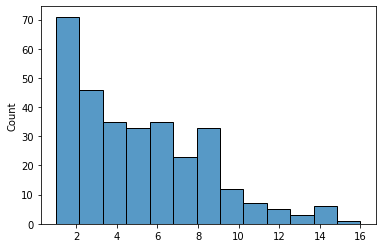

In [16]:
embedding = find_embedding(bqm.quadratic.keys(), qpu_pegasus.edgelist, random_seed=1)

def get_chain_lengths(_embedding):
    lengths = []
    biases = []
    for (key, value) in _embedding.items():
        lengths.append(len(value))
        biases.append(bqm.linear[key])
    return lengths, biases

import seaborn as sns
sns.histplot(get_chain_lengths(embedding)[0])

In [17]:
def count_qubits_used(embedding):
    physical_vars = set()
    for (logic_var, chain) in embedding.items():
        for pv in chain:
            physical_vars.add(pv)
        
    return len(physical_vars)
#count_qubits_used(embedding)

-----------------------

In [ ]:
num_variables_to_mirror = 1
mirrored_variables = []
total_used_qubits = []
for num_variables_to_mirror in range(141):
    
    num_variables, num_clauses, variables, clauses = load_file()
    variables_to_mirror = []
    for i in range(num_variables_to_mirror):
        variables_to_mirror.append(mirror_variable(variables, clauses))
    bqm, or_result_vars, clauses_qubits = cnf_to_bqm(variables, clauses)
    assert(len(bqm.variables) == 308 + num_variables_to_mirror)
    for vtm in variables_to_mirror:
        update_bqm_mirror_variable(vtm[0], vtm[1])
    embedding = find_embedding(bqm.quadratic.keys(), qpu_pegasus.edgelist, random_seed=1)
    mirrored_variables.append(num_variables_to_mirror)
    total_used_qubits.append(count_qubits_used(embedding))
    print(num_variables_to_mirror, count_qubits_used(embedding))

0 1413
1 1467
2 1461
3